# 3 Exploratory Data Analysis

## Table of Contents:

* [3.1 Introduction](#3.1_Introduction)
* [3.2 Import Packages](#3.2_Import_Packages)
* [3.3 Load the Data](#3.3_Load_the_Data)
* [3.4 Exploring the Data](#3.4_Exploring_the_Data)
  * [3.4.1 Shifting the TAC Data](#3.4.1_Shifting_the_TAC_Data)
  * [3.4.2 Imputing the Missing Data](#3.4.2_Imputing_the_Missing_Data)
    * [3.4.2.1 Interpolation](#3.4.2.1_Interpolation)
    * [3.4.2.2 Triangular Moving Average](#3.4.2.2_Triangular_Moving_Average)
  * [3.4.3 Smoothing the Accelerometer Data](#3.4.3_Smoothing_the_Accelerometer_Data)
  * [3.4.4 Featurizing the Accelerometer Data](#3.4.4_Featurizing_the_Accelerometer_Data)
    * [3.4.4.1 Multiprocessing](#3.4.4.1_Multiprocessing)
    * [3.4.4.2 Bifurcating, Featurizing, and Exporting](#3.4.4.2_Bifurcating_Featurizing_and_Exporting)
  * [3.4.5 Investigating Features](#3.4.5_Investigating_Features)
* [3.5 Summary and Next Steps](#3.5_Summary_and_Next_Steps)

## 3.1 Introduction<a id='3.1_Introduction'></a>

From our Data Wrangling step, we had exported 13 CSV files of each participant's accelerometer data, transdermal alcohol content (TAC) data, and each instance's corresponding Unix Timestamp (note: the timestamp has 3 additional units, corresponding to milliseconds). The CSV files were titled in the format "pid[#]_acc_TAC.csv", where "#" ranges from 1 to 13, for the 13 anonymized individuals. We kept the NaN values in the exported CSV, giving us flexibility in this EDA step to determine how we want to shift the data, whether to interpolate, do a running average smoothing, etc. While trying different smoothing methods on the raw TAC data, we found that a rolling window of 1.5 or 2 hours and interpolating with quadratic or cubic methods are most promising of the methods we tried.

In this notebook, we will do the following:

1. __Shift the TAC data (subtract the 45-minute lag).__ This will align drinking activity (i.e. the phone accelerometer data) with changes in TAC.

2. __Smooth/Impute the data.__ Bifurcate the TAC data. With one set, interpolate with polynomial fitting, from the 3rd to the 9th degree. Look at a small window of NaNs and see how much the fitting changes between each change in degree. With the other set, we smooth with a triangular rolling window. Use the same smoothing methods with the accelerometer data.

3. __Featurize accelerometer x-, y-, and z-axis data__, for a total of 10-20 features. We do this for each bifurcated TAC dataset.

4. __Investigate relationships between features.__ Every feature will be investigated, using numerical and visual means such as PCA, heatmaps, box plots, and so forth.

## 3.2 Import Packages<a id='3.2_Import_Packages'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
import timeit
import time
from scipy.stats import skew, kurtosis
import concurrent.futures
import multiprocessing

## 3.3 Load the Data<a id='3.3_Load_the_Data'></a>

In [2]:
# change directories to where the processed data is located.

path = 'data'
os.chdir(path)
os.getcwd()

'C:\\Users\\grace\\Documents\\Data Science Bootcamp\\DSC-projects\\Capstone 2\\Heavy drinking project\\data'

In [3]:
#Load the accelerometer and TAC data for participant 1. Verify it loaded correctly.
columns = ['time', 'x', 'y', 'z', 'TAC Level']
pid1 = pd.read_csv("pid1_acc_TAC.csv", usecols=columns)
pid1.head()

time       x       y       z  TAC Level
0  1493735870653  0.1261 -0.0078 -0.0243        NaN
1  1493735870679  0.1336 -0.0697 -0.0446        NaN
2  1493735870703  0.1443 -0.0474 -0.0447        NaN
3  1493735870729  0.1255 -0.0038  0.0111        NaN
4  1493735870753  0.1076  0.0032  0.0276        NaN

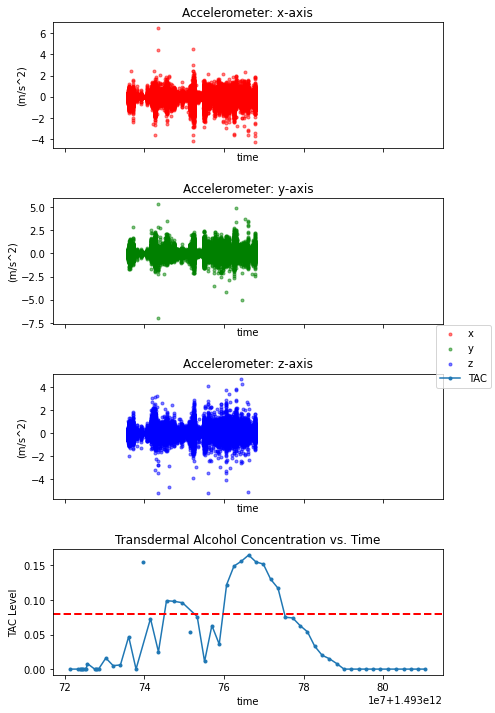

In [4]:
# Plot the accelerometer and TAC data.

def plot_acc_TAC(df, col_name='TAC Level'):
    """This function accepts a dataframe that has x, y, z, and TAC columns; and unix time column.
    It returns a graph that has the x, y, z subplots and TAC line plot as a 4-row subplot."""

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(7,12), sharex=True)

    ax1.scatter(df.time, df.x, label='x', marker='.', alpha=0.5, color='r')
    ax2.scatter(df.time, df.y, label='y', marker='.', alpha=0.5, color='g')
    ax3.scatter(df.time, df.z, label='z', marker='.', alpha=0.5, color='b')
    ax4.plot(df.time, df[col_name], label='TAC', linestyle='-', marker='.')

    ax4.axhline(y=0.08, linewidth=2, color='r', linestyle='--')

    fig.legend(loc='right')
    ax1.set_xlabel('time')
    ax2.set_xlabel('time')
    ax3.set_xlabel('time')
    ax4.set_xlabel('time')

    ax1.set_ylabel('(m/s^2)')
    ax2.set_ylabel('(m/s^2)')
    ax3.set_ylabel('(m/s^2)')
    ax4.set_ylabel('TAC Level')

    ax1.set_title('Accelerometer: x-axis')
    ax2.set_title('Accelerometer: y-axis')
    ax3.set_title('Accelerometer: z-axis')
    ax4.set_title('Transdermal Alcohol Concentration vs. Time')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

    plt.show()

    
# Plot the accelerometer and TAC data for Participant 1.
plot_acc_TAC(pid1)
#Note, this plot looks the same as in the Data Wrangling notebook. We have loaded the file correctly.

In [5]:
#Load the accelerometer and TAC data for participants 2 through 13.
columns = ['time', 'pid', 'x', 'y', 'z', 'TAC Level']
pid2 = pd.read_csv("pid2_acc_TAC.csv", usecols=columns)
pid3 = pd.read_csv("pid3_acc_TAC.csv", usecols=columns)
pid4 = pd.read_csv("pid4_acc_TAC.csv", usecols=columns)
pid5 = pd.read_csv("pid5_acc_TAC.csv", usecols=columns)
pid6 = pd.read_csv("pid6_acc_TAC.csv", usecols=columns)
pid7 = pd.read_csv("pid7_acc_TAC.csv", usecols=columns)
pid8 = pd.read_csv("pid8_acc_TAC.csv", usecols=columns)
pid9 = pd.read_csv("pid9_acc_TAC.csv", usecols=columns)
pid10 = pd.read_csv("pid10_acc_TAC.csv", usecols=columns)
pid11 = pd.read_csv("pid11_acc_TAC.csv", usecols=columns)
pid12 = pd.read_csv("pid12_acc_TAC.csv", usecols=columns)
pid13 = pd.read_csv("pid13_acc_TAC.csv", usecols=columns)

In [6]:
#Put all of the loaded data into an easily accessible list.
pid_list = [pid1, pid2, pid3, pid4, pid5, pid6, pid7, pid8, pid9, pid10, pid11, pid12, pid13]

At this point we have loaded all of our data for all 13 of our anonymized individuals.

## 3.4 Exploring the Data<a id='3.4_Exploring_the_Data'></a>

### 3.4.1 Shifting the TAC Data<a id='3.4.1_Shifting_the_TAC_Data'></a>

There is generally a 45-minute to 2-hour lag between alcohol ingestion and transdermal alcohol readings. According to the authors of this dataset, the manufacturer of the SCRAM bracelets used in this study state that there is an approximate 45-minute lag between alcohol entering the blood stream and the SCRAM device reporting the observation in the user's sweat. Other academic papers argue that this lag can extend up to 2-hours, depending on the individual's sex, weight, and number of drinks consumed. Due to our lack of identifying information on the individuals in this dataset, we will follow the authors' lead and shift the TAC data by 45-minutes.

In [7]:
#Every TAC output needs to be shifted by 45 minutes, or 2700 seconds.
#Since the 'time' column is in milliseconds, we need to shift everything back by 2,700,000 milliseconds.

def shift_45_minutes(df):
    """Copies the 'TAC Level' column and its corresponding unix timestamp, shifts it by 45 minutes
    (or 2,700,000 milliseconds), and appends it to the dataframe as a new column called 'TAC_shifted'.
    Deletes the original 'TAC Level' column."""
    TAC = df[['time','TAC Level']].dropna()
    acc = df[['time', 'x', 'y', 'z']].dropna()
    TAC_shifted = TAC.sub([2700000, 0], axis='columns') #subtract 2700000 millisec from time column
    TAC_renamed = TAC_shifted.rename(columns={"TAC Level": "TAC_shifted"}) #rename the column
    combined = pd.merge(acc, TAC_renamed, how='outer', on='time') #merge the two df's
    return combined

In [8]:
#Test out the 45-minute shift function with pid1.

pid1 = pd.read_csv("pid1_acc_TAC.csv", usecols=columns) #we keep this here to reset pid1 as needed.
pid1_shift = shift_45_minutes(pid1)
pid1_shift.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225784 entries, 0 to 1225783
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   time         1225784 non-null  int64  
 1   x            1225727 non-null  float64
 2   y            1225727 non-null  float64
 3   z            1225727 non-null  float64
 4   TAC_shifted  57 non-null       float64
dtypes: float64(4), int64(1)
memory usage: 56.1 MB


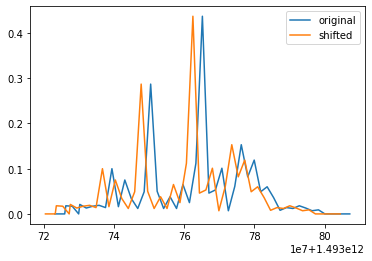

In [9]:
#Test out the 45-minute shift visually, with pid2.
pid2_shift = shift_45_minutes(pid2)
_=plt.plot(pid2.time, pid2['TAC Level'], label='original')
_=plt.plot(pid2_shift.time, pid2_shift.TAC_shifted, label='shifted')
_=plt.legend(loc='upper right')

In [10]:
#These lines of code can help to reset the dataframs prior to being shifted.
#remove the comments to run the lines of code.

#columns = ['time', 'pid', 'x', 'y', 'z', 'TAC Level']
#pid1 = pd.read_csv("pid1_acc_TAC.csv", usecols=columns)
#pid2 = pd.read_csv("pid2_acc_TAC.csv", usecols=columns)
#pid3 = pd.read_csv("pid3_acc_TAC.csv", usecols=columns)
#pid4 = pd.read_csv("pid4_acc_TAC.csv", usecols=columns)
#pid5 = pd.read_csv("pid5_acc_TAC.csv", usecols=columns)
#pid6 = pd.read_csv("pid6_acc_TAC.csv", usecols=columns)
#pid7 = pd.read_csv("pid7_acc_TAC.csv", usecols=columns)
#pid8 = pd.read_csv("pid8_acc_TAC.csv", usecols=columns)
#pid9 = pd.read_csv("pid9_acc_TAC.csv", usecols=columns)
#pid10 = pd.read_csv("pid10_acc_TAC.csv", usecols=columns)
#pid11 = pd.read_csv("pid11_acc_TAC.csv", usecols=columns)
#pid12 = pd.read_csv("pid12_acc_TAC.csv", usecols=columns)
#pid13 = pd.read_csv("pid13_acc_TAC.csv", usecols=columns)

#pid_list = [pid1, pid2, pid3, pid4, pid5, pid6, pid7, pid8, pid9, pid10, pid11, pid12, pid13]

In [11]:
#shift all of the TAC data by 45 minutes, for all 13 individuals.

for i in range(13):
    pid_list[i] = shift_45_minutes(pid_list[i])

#Note: this affects pid1 through pid13 in the "pid_list" list. 
#But it does not affect the earlier pid1-pid13 dataframes not in the list.

#Let's make individual shifted dataframes.
pid1_shift = pid_list[0]
pid2_shift = pid_list[1]
pid3_shift = pid_list[2]
pid4_shift = pid_list[3]
pid5_shift = pid_list[4]
pid6_shift = pid_list[5]
pid7_shift = pid_list[6]
pid8_shift = pid_list[7]
pid9_shift = pid_list[8]
pid10_shift = pid_list[9]
pid11_shift = pid_list[10]
pid12_shift = pid_list[11]
pid13_shift = pid_list[12]

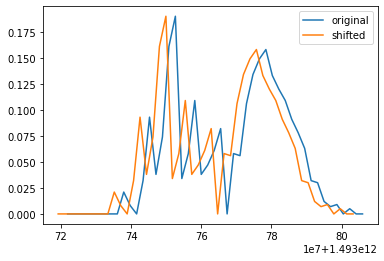

In [12]:
#verify this works for pid4 in the pid_list.
pid4_shift = pid_list[3]
_=plt.plot(pid4.time, pid4['TAC Level'], label='original')
_=plt.plot(pid4_shift.time, pid4_shift.TAC_shifted, label='shifted')
_=plt.legend(loc='upper right')

### 3.4.2 Imputing the Missing Data<a id='3.4.2_Imputing_the_Missing_Data'></a>

In the previous notebook (Data Wrangling), while trying different smoothing methods on the raw TAC data, we found that a rolling window of 1.5 or 2 hours and interpolating with quadratic or cubic methods appeared to be promising.

In this step, we will bifurcate the data and impute the missing TAC data. We will either interpolate it with polynomial fitting smooth it with a triangular moving average (followed by interpolating with a polynomial fitting). 
 * We will use scipy interpolate() method in order to interpolate with polynomial fitting of varying degrees.
 * We will use the pandas rolling() method for triangular moving average to smooth, followed by interpolation to impute the missing data.

For interpolating (without TMA), we will try polynomial fitting from the 3rd to the 9th degree.  We can observe how much the fitting changes between each change in degree by plotting a small window of NaN's.

Triangular moving average (TMA) is averaged twice, so it places more weight on the middle portion of the data. For the TMA, we'll use a rolling window of 1.5 hours (i.e. 3 data points). Since many of the rows with accelerometer values will still read NaN in the TAC column, we can impute those TAC values using a linear interpolation of the TAC data. 

At the end of this section, we should have the following in each dataframe:
 * Columns with TAC values interpolated by polynomial fitting where degree = 3, 5, 7, 9.
 * Column with TAC values smoothed by TMA (window = 3, corresponding to 1.5 hours), followed by cubic (3rd degree) interpolation.


#### 3.4.2.1 Interpolation<a id='3.4.2.1_Interpolation'></a>

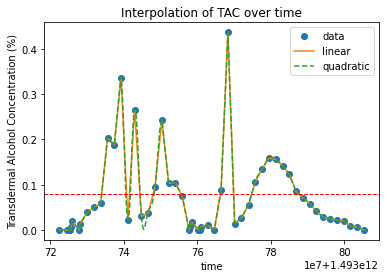

In [13]:
#Separate the TAC data as a numpy array, and use scipy.interpolate function interp1d.

from scipy.interpolate import interp1d

def polynomial_smooth_plot(df, col_name = 'TAC_shifted'):
    '''This function takes the specified column from the dataframe, converts it to a numpy array, and 
    interpolates it with scipy.interpolate interp1d, kind = linear, quadratic, cubic. 
    The results are displayed in a graph.'''
    
    df_sorted = df.sort_values(by='time').reset_index(drop=True) #keep all NaN values. Use this for prediction.
    df_clean = df_sorted[['time', col_name]].dropna() #drop all NaN values. Use this for training.
    
    x = df_clean['time'].to_numpy()
    y = df_clean[col_name].to_numpy()
    xnew = df_sorted['time'].to_numpy()

    f = interp1d(x, y)
    f2 = interp1d(x, y, kind='quadratic')
    f3 = interp1d(x, y, kind='cubic')
    
    plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
    plt.legend(['data', 'linear', 'quadratic'], loc='best')
    plt.xlabel('time')
    plt.ylabel('Transdermal Alcohol Concentration (%)')
    plt.axhline(y=0.08, linewidth=1, linestyle='--', color='r')
    plt.title('Interpolation of TAC over time')
    plt.show()

#test with pid13_shift
polynomial_smooth_plot(pid13_shift)

In [14]:
#Same as above, but return a pandas dataframe with the results as columns.

def polynomial_smooth(df, col_name = 'TAC_shifted'):
    '''This function takes the specified column from the dataframe, converts it to a numpy array, and 
    interpolates it with scipy.interpolate interp1d. Degree/Order is specified as 3, 5, 7, 9. 
    This returns a pandas dataframe with each interpolation as a column.'''
    
    df_sorted = df.sort_values(by='time').reset_index(drop=True) #keep all NaN values. Use this for prediction.
    
    #Note: pid3_shift has issue where the accelerometer data goes on longer than the TAC data, 
    #and we get an error later in the code ("A value in x_new is above the interpolation range.")
    #Therefore, we need to drop all the rows after the end of the TAC data.
    max_TAC_time = max(df_sorted[['time', col_name]].dropna()['time'])
    ending_index = df_sorted[df_sorted.time == max_TAC_time].index[0] + 1 #index starts at 0, make sure to +1
    df_trimmed = df_sorted
    df_trimmed = df_trimmed[0:ending_index]
    
    df_clean = df_trimmed[['time', col_name]].dropna() #drop all NaN values. Use this for training.

    
    x = df_clean['time'].to_numpy()
    y = df_clean[col_name].to_numpy()
    xnew = df_trimmed['time'].to_numpy() #use df_trimmed instead of df_sorted, to ensure xnew is within range.
    
    order = [3, 5, 7, 9]
    
    for i in order:
        f = interp1d(x, y, kind=i)
        df_trimmed['order_'+str(i)] = f(xnew)

    
    df_drop_raw = df_trimmed.drop(columns=[col_name]) #drop the original column
#    df_results = df_drop_raw.dropna() #drops all NaN values. Keeps only the rows with accelerometer data.
#    return df_results
    return df_drop_raw


test = polynomial_smooth(pid13_shift).dropna()
test.info() #check to see there are no NaN values

<ipython-input-14-55599624f075>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['order_'+str(i)] = f(xnew)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 662949 entries, 14 to 662994
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time     662949 non-null  int64  
 1   x        662949 non-null  float64
 2   y        662949 non-null  float64
 3   z        662949 non-null  float64
 4   order_3  662949 non-null  float64
 5   order_5  662949 non-null  float64
 6   order_7  662949 non-null  float64
 7   order_9  662949 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 45.5 MB


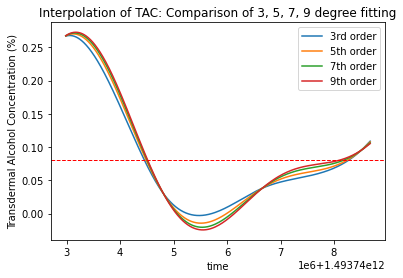

In [15]:
#Using the 'test' dataframe from earlier, take a section with lots of accelerometer data
#(and therefore where the TAC data used to be NaN values)
#and see how the interpolation differs between 3rd, 5th, 7th, and 9th degree.

x=test.time[150000:370000]
y1=test.order_3[150000:370000]
y2=test.order_5[150000:370000]
y3=test.order_7[150000:370000]
y4=test.order_9[150000:370000]
_=plt.plot(x, y1, '-', x, y2, '-', x, y3, '-', x, y4, '-')
_=plt.legend(['3rd order', '5th order', '7th order', '9th order'], loc='best')
_=plt.xlabel('time')
_=plt.ylabel('Transdermal Alcohol Concentration (%)')
_=plt.title('Interpolation of TAC: Comparison of 3, 5, 7, 9 degree fitting')
_=plt.axhline(y=0.08, linewidth=1, linestyle='--', color='r')
_=plt.show()

We see here there are slight differences in the interpolated TAC values between 3, 5, 7, and 9 degree interpolations. It does not appear to be significantly different from each other, though we will keep them to determine later which degree was the optimal fitting when we use our classifier model, to predict when someone is legally drunk (TAC >= 0.08) or not (TAC < 0.08). 

The triangular moving average will likely produce a significantly different result as we do a rolling TMA prior to interpolating.

Note: If you play around with the ranges that you plot, you would find certain jagged sections of the plot where it appears no interpolation occured. This is due to dropping the NaN values after running our polynomial_smooth() function. If you were to run plot_acc_TAC() on the dataframe, you would find that the interpolation is only smooth where there is abundant accelerometer data.

In [16]:
#We use our polynomial_smooth() function on all of the shifted datasets to interpolate.

pid1_interpolate = polynomial_smooth(pid1_shift).dropna()
pid2_interpolate = polynomial_smooth(pid2_shift).dropna()
pid3_interpolate = polynomial_smooth(pid3_shift).dropna()
pid4_interpolate = polynomial_smooth(pid4_shift).dropna()
pid5_interpolate = polynomial_smooth(pid5_shift).dropna()
pid6_interpolate = polynomial_smooth(pid6_shift).dropna()
pid7_interpolate = polynomial_smooth(pid7_shift).dropna()
pid8_interpolate = polynomial_smooth(pid8_shift).dropna()
pid9_interpolate = polynomial_smooth(pid9_shift).dropna()
pid10_interpolate = polynomial_smooth(pid10_shift).dropna()
pid11_interpolate = polynomial_smooth(pid11_shift).dropna()
pid12_interpolate = polynomial_smooth(pid12_shift).dropna()
pid13_interpolate = polynomial_smooth(pid13_shift).dropna()

<ipython-input-14-55599624f075>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['order_'+str(i)] = f(xnew)


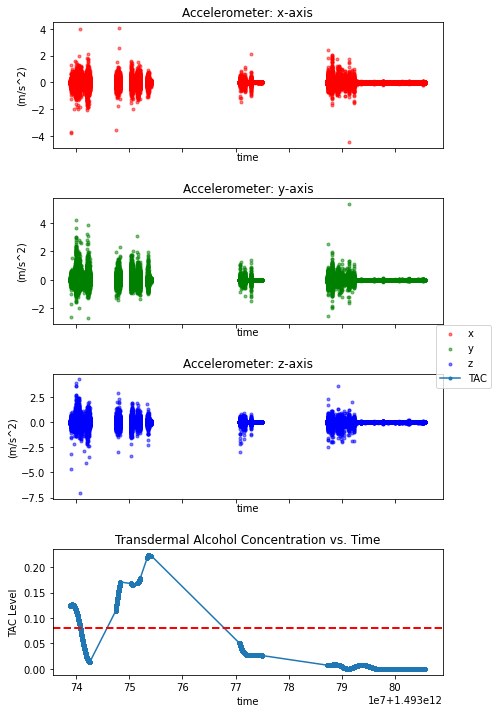

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117017 entries, 18 to 1117068
Data columns (total 8 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   time     1117017 non-null  int64  
 1   x        1117017 non-null  float64
 2   y        1117017 non-null  float64
 3   z        1117017 non-null  float64
 4   order_3  1117017 non-null  float64
 5   order_5  1117017 non-null  float64
 6   order_7  1117017 non-null  float64
 7   order_9  1117017 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 76.7 MB
None


In [17]:
#Check that this worked. 
#Use pid6, as the original raw data had accelerometer data longer than the TAC data, 
#and it has many gaps in the data.
plot_acc_TAC(pid6_interpolate, col_name = 'order_3')
print(pid6_interpolate.info())

#### 3.4.2.2 Triangular Moving Average<a id='3.4.2.2_Triangular_Moving_Average'></a>

Using our shifted data (pid#_shift), we smooth the TAC data by calculating the TMA (window = 3, corresponding to 1.5 hours), followed by cubic (3rd degree) interpolation.

In [18]:
def tma_smooth(df, col_name = 'TAC_shifted'):
    '''This function takes the specified column from the dataframe, uses the pandas rolling() 
    function to smooth the TAC_shifted column using a triangular moving average (TMA), window size 3.
    This is followed by an interpolation of a cubic fitting.'''
    
    df_sorted = df.sort_values(by='time').reset_index(drop=True) #keep all NaN values. Use this for prediction.
    max_TAC_time = max(df_sorted[['time', col_name]].dropna()['time'])
    ending_index = df_sorted[df_sorted.time == max_TAC_time].index[0] + 1 #index starts at 0, make sure to +1
    df_trimmed = df_sorted
    df_trimmed = df_trimmed[0:ending_index]
    
    df_clean = df_trimmed[['time', col_name]].dropna() #drop all NaN values. Use this for training.
    df_tma = df_clean[col_name].rolling(3, center=True, win_type='triang').mean() #use triangular moving average
    df_tma_np = df_tma.to_numpy()
    
    df_tma_np[0] = df_clean[col_name].iloc[0]
    df_tma_np[-1] = df_clean[col_name].iloc[-1]
    
    x = df_clean['time'].to_numpy()
    y = df_tma_np
    xnew = df_trimmed['time'].to_numpy() 

    f = interp1d(x, y, kind=3) #cubic interpolation
    df_trimmed['tma'] = f(xnew)

    
    df_drop_raw = df_trimmed.drop(columns=[col_name]) #drop the original column
#    df_results = df_drop_raw.dropna() #drops all NaN values. Keeps only the rows with accelerometer data.
#    return df_results
    return df_drop_raw

tma_test = tma_smooth(pid4_shift)
tma_test.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591358 entries, 18 to 591393
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    591358 non-null  int64  
 1   x       591358 non-null  float64
 2   y       591358 non-null  float64
 3   z       591358 non-null  float64
 4   tma     591358 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 27.1 MB


<ipython-input-18-4e90746d2de2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['tma'] = f(xnew)


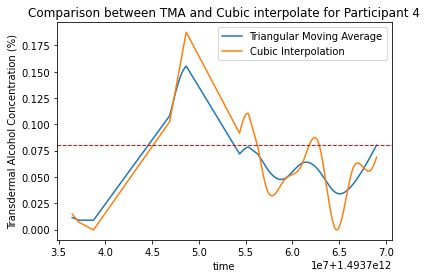

In [19]:
#do a small comparison between the tma smooth and regular interpolation
#compare pid4 data with TMA vs cubic interpolation.
_=plt.plot(tma_test.dropna().time, tma_test.dropna().tma)
_=plt.plot(pid4_interpolate.time, pid4_interpolate.order_3)
_=plt.legend(['Triangular Moving Average', 'Cubic Interpolation'], loc='best')
_=plt.xlabel('time')
_=plt.ylabel('Transdermal Alcohol Concentration (%)')
_=plt.title('Comparison between TMA and Cubic interpolate for Participant 4')
_=plt.axhline(y=0.08, linewidth=1, linestyle='--', color='r')
_=plt.show()

The jaggedness in the data for participant 4 reflects the missing accelerometer data. In the latter half of the plot, where the accelerometer data is more prominent, we can see more clearly the differences in just interpolation versus running a triangular moving average prior to interpolation.

In [20]:
#run TMA smooth on every pid#_shift, and append the TMA data to the interpolate data
pid1_interpolate['tma'] = tma_smooth(pid1_shift).dropna()['tma']
pid2_interpolate['tma'] = tma_smooth(pid2_shift).dropna()['tma']
pid3_interpolate['tma'] = tma_smooth(pid3_shift).dropna()['tma']
pid4_interpolate['tma'] = tma_smooth(pid4_shift).dropna()['tma']
pid5_interpolate['tma'] = tma_smooth(pid5_shift).dropna()['tma']
pid6_interpolate['tma'] = tma_smooth(pid6_shift).dropna()['tma']
pid7_interpolate['tma'] = tma_smooth(pid7_shift).dropna()['tma']
pid8_interpolate['tma'] = tma_smooth(pid8_shift).dropna()['tma']
pid9_interpolate['tma'] = tma_smooth(pid9_shift).dropna()['tma']
pid10_interpolate['tma'] = tma_smooth(pid10_shift).dropna()['tma']
pid11_interpolate['tma'] = tma_smooth(pid11_shift).dropna()['tma']
pid12_interpolate['tma'] = tma_smooth(pid12_shift).dropna()['tma']
pid13_interpolate['tma'] = tma_smooth(pid13_shift).dropna()['tma']

<ipython-input-18-4e90746d2de2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['tma'] = f(xnew)


In [21]:
#check to see if the previous step worked
pid10_interpolate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631303 entries, 18 to 631346
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time     631303 non-null  int64  
 1   x        631303 non-null  float64
 2   y        631303 non-null  float64
 3   z        631303 non-null  float64
 4   order_3  631303 non-null  float64
 5   order_5  631303 non-null  float64
 6   order_7  631303 non-null  float64
 7   order_9  631303 non-null  float64
 8   tma      631303 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 48.2 MB


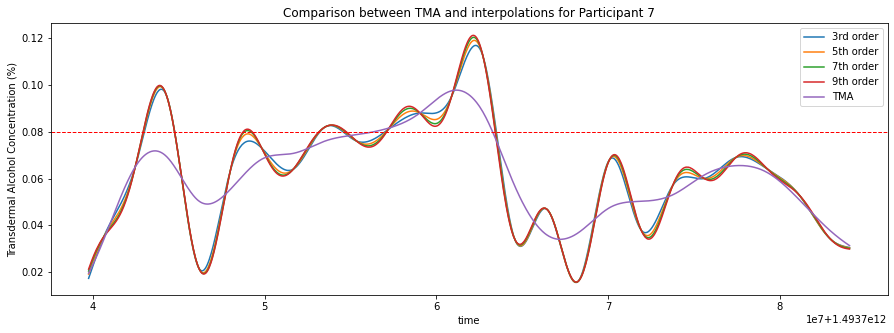

In [22]:
#try plotting and comparing TMA and the other interpolations
fig, ax = plt.subplots(figsize=(15,5))
df=pid7_interpolate
_=plt.plot(df.time, df.order_3, df.time, df.order_5, df.time, df.order_7, df.time, df.order_9, df.time, df.tma)
_=plt.legend(['3rd order', '5th order', '7th order', '9th order', 'TMA'], loc='best')
_=plt.xlabel('time')
_=plt.ylabel('Transdermal Alcohol Concentration (%)')
_=plt.title('Comparison between TMA and interpolations for Participant 7')
_=plt.axhline(y=0.08, linewidth=1, linestyle='--', color='r')
_=plt.show()

In this last plot we can more clearly see the difference between strictly interpolating the TAC datavalues, and running a Triangular Moving Average followed by interpolating (of the 3rd order). We can expect to see more varying results between the interpolated data and the TMA data when we try predicting with our models.

### 3.4.3 Smoothing the Accelerometer Data<a id='3.4.3_Smoothing_the_Accelerometer_Data'></a>

Similarly to how we smoothed the TAC data, we should also smooth the accelerometer data. The authors of the dataset using the same low-pass filter on both the TAC and accelerometer data, but in a 2010 paper ("Activity Recognition using Cell Phone Accelerometers", J.R. Kwapisz, G.M. Weiss, S.A. Moore, DOI: 10.1145/1964897.1964918) we see the authors use the raw accelerometer data.

For the Triangular Moving Average (TMA) TAC data, we will also use TMA to smooth the accelerometer data. For the interpolated data, since nothing was actually smoothed/averaged and we simply imputed the NaN values, we will keep the raw accelerometer data.

For consistency and simplicity, we use the same TMA with window size 3 to smooth the accelerometer data. Possibly in a future project we can automate this process to optimize the smoothing method, window size, interpolation, etc. 

In [23]:
def tma_acc(df):
    """This function takes the x, y, and z columns from the dataframe, uses the pandas rolling() 
    function to smooth the TAC_shifted column using a triangular moving average (TMA), window size 3.
    The original dataframe is return with these new columns appended."""

    df_copy = df.reset_index(drop=True) #reset index so we can select the first and last rows by index
   
    df_copy['x_tma'] = df_copy.x.rolling(3, center=True, win_type='triang').mean()
    df_copy['y_tma'] = df_copy.y.rolling(3, center=True, win_type='triang').mean()
    df_copy['z_tma'] = df_copy.z.rolling(3, center=True, win_type='triang').mean()
        
    #after averaging, our first and last rows are NaN values.
    #impute the the first and last rows with the raw accelerometer data.

    df_copy.iloc[0,9] = df.x.iloc[0]
    df_copy.iloc[-1,9] = df.x.iloc[-1]
    
    df_copy.iloc[0,10] = df.y.iloc[0]
    df_copy.iloc[-1,10] = df.y.iloc[-1]
    
    df_copy.iloc[0,11] = df.z.iloc[0]
    df_copy.iloc[-1,11] = df.z.iloc[-1]
    
    return df_copy

In [24]:
# test to see if it works
pid2_tma = tma_acc(pid2_interpolate)
pid2_tma.head()

time       x       y       z   order_3   order_5   order_7  \
0  1493737404780 -0.0094  0.0147  0.0186  0.077353  0.076486  0.074826   
1  1493737404807 -0.0001  0.0126  0.0168  0.077352  0.076484  0.074824   
2  1493737404830  0.0091  0.0017  0.0164  0.077350  0.076483  0.074823   
3  1493737404857  0.0088 -0.0004  0.0177  0.077349  0.076482  0.074821   
4  1493737404881  0.0088  0.0039  0.0119  0.077347  0.076480  0.074820   

    order_9      tma     x_tma   y_tma     z_tma  
0  0.075057  0.05739 -0.009400  0.0147  0.018600  
1  0.075055  0.05739 -0.000125  0.0104  0.017150  
2  0.075054  0.05739  0.006725  0.0039  0.016825  
3  0.075052  0.05739  0.008875  0.0012  0.015925  
4  0.075051  0.05739  0.009250  0.0037  0.012650

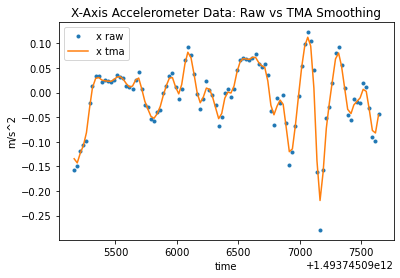

In [25]:
df=pid2_tma[40000:40100]
_=plt.plot(df.time, df.x, '.', df.time, df.x_tma, '-' )
_=plt.legend(['x raw', 'x tma'], loc='best')
_=plt.xlabel('time')
_=plt.ylabel('m/s^2')
_=plt.title('X-Axis Accelerometer Data: Raw vs TMA Smoothing')
_=plt.show()

In [26]:
#run TMA smooth on the accelerometer columns of every pid#_shift
pid1_tma = tma_acc(pid1_interpolate)
pid2_tma = tma_acc(pid2_interpolate)
pid3_tma = tma_acc(pid3_interpolate)
pid4_tma = tma_acc(pid4_interpolate)
pid5_tma = tma_acc(pid5_interpolate)
pid6_tma = tma_acc(pid6_interpolate)
pid7_tma = tma_acc(pid7_interpolate)
pid8_tma = tma_acc(pid8_interpolate)
pid9_tma = tma_acc(pid9_interpolate)
pid10_tma = tma_acc(pid10_interpolate)
pid11_tma = tma_acc(pid11_interpolate)
pid12_tma = tma_acc(pid12_interpolate)
pid13_tma = tma_acc(pid13_interpolate)

There are segments of the accelerometer data with zero-data or missing readings. The authors of the dataset indicate that it may have been due to occasional periods of lost internet connection or loss of battery power. This should appear as missing data (i.e. no data values in the accelerometer data), but we should check to make sure we don't have long spans of 0-values in the x,y,z axes.

In [27]:
# Let us first check the raw accelerometer data (x, y, z) whether there is any instance where 0's is recorded
# in all 3 axes. This would indicate times where the participant was not moving, or the phone was laid flat, 
# and these sections may need to be dropped since it does not give us information on a person's movement and its
# subsequent relationship to alcohol concentration.

pid_tma_list = [pid1_tma, pid2_tma, pid3_tma, pid4_tma, pid5_tma, pid6_tma, \
                pid7_tma, pid8_tma, pid9_tma, pid10_tma, pid11_tma, pid12_tma, pid13_tma]

for i in range(13):
    df = pid_tma_list[i]
    zeroes = len(df.loc[(df.x == 0) & (df.y==0) & (df.z==0)])
    print("PID", i+1, ":", zeroes)

PID 1 : 0
PID 2 : 0
PID 3 : 0
PID 4 : 2
PID 5 : 0
PID 6 : 7
PID 7 : 0
PID 8 : 0
PID 9 : 0
PID 10 : 2
PID 11 : 2
PID 12 : 0
PID 13 : 1


In [28]:
#PID 6 had the most instances with 0's. Check to see if these values are adjacent to each other. 
df=pid6_tma
df.loc[(df.x == 0) & (df.y==0) & (df.z==0)]

#From here, we see that each of these rows are separated by 26 seconds or more. 
#The accelerometer reading 0's is just a coincidence.

time    x    y    z   order_3   order_5   order_7   order_9  \
250657  1493771602313 -0.0 -0.0 -0.0  0.031423  0.027850  0.026068  0.025117   
251702  1493771628557  0.0  0.0  0.0  0.031135  0.027574  0.025788  0.024833   
269907  1493772085865  0.0 -0.0 -0.0  0.027930  0.025593  0.024299  0.023570   
272074  1493772140281  0.0  0.0 -0.0  0.027734  0.025636  0.024460  0.023794   
277148  1493772267708 -0.0 -0.0  0.0  0.027386  0.025887  0.025023  0.024527   
282746  1493772408319  0.0  0.0 -0.0  0.027147  0.026343  0.025865  0.025588   
289399  1493772575372 -0.0 -0.0 -0.0  0.026998  0.027014  0.027024  0.027030   

             tma     x_tma     y_tma     z_tma  
250657  0.045316 -0.000125 -0.000075 -0.000125  
251702  0.044926 -0.000175  0.000025 -0.000025  
269907  0.038509 -0.000500 -0.000250  0.000025  
272074  0.037811 -0.000200  0.000000 -0.000175  
277148  0.036247 -0.000150  0.000250 -0.000175  
282746  0.034654 -0.000150 -0.000225 -0.000200  
289399  0.032968 -0.000600 -0.000200  0.000200

We don't need to worry about long spans of 0-value accelerometer data. We can go ahead and featurize the data.

### 3.4.4 Featurizing the Accelerometer Data<a id='3.4.4_Featurizing_the_Accelerometer_Data'></a>

From Killian et al. (2019) (the authors of this dataset) and Kwapisz et al. (2010), both used a 10-second window to featurize the accelerometer data. In fact, Killian et al. found that the 10-second window performed best in terms of accuracy compared to other window lengths. We can optimize this window size in the future, but for now the 10-second window will be our starting point.

There are many different ways to featurize the accelerometer data. Because we have x, y, z, x_tma, y_tma, and z_tma axes, our features would be in 6's (twice-triplicate). Some features we can extract from each window of the accelerometer data are:
 * Mean
 * Standard Deviation
 * Variance
 * Median
 * Max (of raw and of absolute signal)
 * Min (of raw and of absolute signal)
 * Skew
 * Kurtosis
 * Zero Crossing Rate - the number of times the signal changes signs.
 * Gait stretch - the difference between max and min of one stride (of raw signal).
 * Number of steps - the total number of peaks.
 * Step Time - the average time between steps.
 * RMS - Root-mean-square of accelerations, i.e. the average power.
 * Average Resultant Acceleration - Average of the square roots of the sum of the values of each axis squared: $\sqrt{x^{2} + y^{2} + z^{2}}$
 * Jerk (the gradient of the accelerometer data) and the above features for Jerk.
 * Snap (the gradient of jerk) and the above features for Snap. 

We can use the pandas .rolling() function in combination with .mean(), .std(), etc. to make new columns with features.

In [29]:
# First we must convert the indexes back into datetime indexes.
# This will allow us to us the pandas rolling function to featurize 10-second windows,
# regardless of the number of instances in each window.

def convert_datetime(df):
    """Converts the 'time' column in a dataframe from int64 to datetime64, then sets the datetime column as index."""
    dt = pd.to_datetime(df['time'], unit='ms', origin='unix').to_numpy()
    df.loc[:,'time'] = dt
    df = df.set_index('time')
    return df

test = convert_datetime(pid1_tma)
test.tail()

x       y       z   order_3   order_5   order_7  \
time                                                                            
2017-05-02 23:29:30.540 -0.0784 -0.0161  0.1719  0.145801  0.145397  0.144890   
2017-05-02 23:29:30.564 -0.0395 -0.0816  0.1634  0.145800  0.145397  0.144889   
2017-05-02 23:29:30.590  0.0160 -0.0853  0.0906  0.145800  0.145396  0.144889   
2017-05-02 23:29:30.614  0.0901 -0.0767  0.0162  0.145800  0.145396  0.144889   
2017-05-02 23:29:30.640  0.1700 -0.1390 -0.0773  0.145799  0.145396  0.144888   

                          order_9       tma     x_tma     y_tma     z_tma  
time                                                                       
2017-05-02 23:29:30.540  0.144350  0.143201 -0.087025  0.000100  0.201200  
2017-05-02 23:29:30.564  0.144350  0.143200 -0.035350 -0.066150  0.147325  
2017-05-02 23:29:30.590  0.144349  0.143200  0.020650 -0.082225  0.090200  
2017-05-02 23:29:30.614  0.144349  0.143200  0.091550 -0.094425  0.011425  
2017-05-02 23:29:30.640  0.144349  0.143200  0.170000 -0.139000 -0.077300

In [30]:
#Use convert_datetime on all of our data
pid1_dt = convert_datetime(pid1_tma)
pid2_dt = convert_datetime(pid2_tma)
pid3_dt = convert_datetime(pid3_tma)
pid4_dt = convert_datetime(pid4_tma)
pid5_dt = convert_datetime(pid5_tma)
pid6_dt = convert_datetime(pid6_tma)
pid7_dt = convert_datetime(pid7_tma)
pid8_dt = convert_datetime(pid8_tma)
pid9_dt = convert_datetime(pid9_tma)
pid10_dt = convert_datetime(pid10_tma)
pid11_dt = convert_datetime(pid11_tma)
pid12_dt = convert_datetime(pid12_tma)
pid13_dt = convert_datetime(pid13_tma)

We can define a function that uses the pandas function .rolling('10s') to featurize our accelerometer data in 10-second windows. While putting together our list of features in our function, it is good to check if our features make sense. Here, we take a quick visual inspection of the number of steps taken per 10s window along the x-axis.

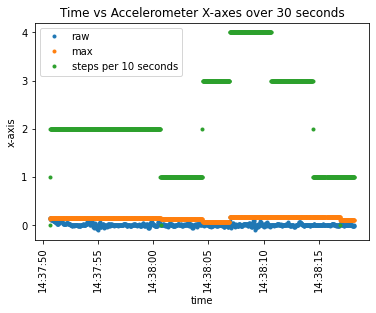

In [31]:
#Test out a few features and plot them.

df =  pid1_dt[0:30000].copy()
col='x'
df[col+'_max_raw'] = df[col].rolling('10s').max()
# df[col+'_min_raw'] = df[col].rolling('10s').min()
# df[col+'_gait_stretch'] = df[col+'_max_raw'] - df[col+'_min_raw'] 
df[col+'_steps'] = df[col+'_max_raw'].rolling('10s').apply(lambda a: (np.diff(a) != 0).sum().astype(int))

#plot the raw x, max x, and number of steps/maxima in a 10s window
b = df[0:1100]
_=plt.plot(b.index, b.x, '.', b.index, b.x_max_raw,'.', b.index, b.x_steps, '.')
_=plt.legend(['raw', 'max', 'steps per 10 seconds'], loc='best')
_=plt.ylabel('x-axis')
_=plt.xlabel('time')
_=plt.xticks(rotation=90) 
_=plt.title('Time vs Accelerometer X-axes over 30 seconds')

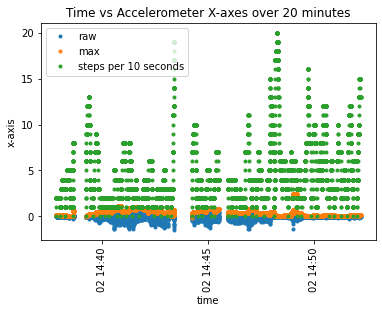

In [32]:
#plot the raw x, max x, and number of steps/maxima in a 10s window, this time over several hours.

b = df

_=plt.plot(b.index, b.x, '.', b.index, b.x_max_raw,'.', b.index, b.x_steps, '.')
#_=plt.plot(b.index, b.x, '.', b.index, b.x_gait_stretch,'.')
_=plt.legend(['raw', 'max', 'steps per 10 seconds'], loc='best')
_=plt.ylabel('x-axis')
_=plt.xlabel('time')
_=plt.xticks(rotation=90) 
_=plt.title('Time vs Accelerometer X-axes over 20 minutes')

Initially in our first graph, it seems a bit strange that someone would take only 4 steps in 10 seconds, but when we plot several hours of data, we see that the individual sometimes takes up to 20 steps (possibly they are running, or their cell phone is jostling in their pocket). This variation seems fairly reasonable.

Below, we create several functions to more efficiently featurize the columns of our dataframes.

In [33]:
#Create functions to featurize our columns.

def featurize_column(df, col):
    """Featurizes the dataframe by 10-second windows. Features include mean, std, zero crossing rate, etc.
    Column must be specified (i.e. featurizes from x, y, z, x_tma, y_tma, or z_tma).
    Features are derived from the accelerometer data and not from the TAC columns."""
    
    def featurize(col):
        df[col+'_mean'] = df[col].rolling('10s').mean()
        df[col+'_std'] = df[col].rolling('10s').std()
        df[col+'_var'] = df[col+'_std']**2
        df[col+'_median'] = df[col].rolling('10s').median()
        df[col+'_max_raw'] = df[col].rolling('10s').max()
        df[col+'_min_raw'] = df[col].rolling('10s').min()
        df[col+'_max_abs'] = (np.absolute(df[col])).rolling('10s').max()
        df[col+'_min_abs'] = (np.absolute(df[col])).rolling('10s').min()
        df[col+'_skew'] = df[col].rolling('10s').skew()
        df[col+'_kurtosis'] = df[col].rolling('10s').apply(lambda a: kurtosis(a))
            #Zero Crossing Rate
        df[col+'_zcr'] = df[col].rolling('10s').apply(lambda a: (np.diff(np.sign(a)) != 0).sum().astype(int)) 
            #Gait stretch - the difference between max and min of one stride.
        df[col+'_gait_stretch'] = df[col+'_max_raw'] - df[col+'_min_raw'] 
            #Number of steps - the total number of peaks (maxima) in a window.
        df[col+'_steps'] = df[col+'_max_raw'].rolling('10s').apply(lambda a: (np.diff(a) != 0).sum().astype(int)) 
            #Step Time - average time between steps.
        df[col+'_step_time'] = 10/df[col+'_steps'] #10 second window divided by number of steps
            #Root Mean Squared
        df[col+'_rms'] = df[col].rolling('10s').apply(lambda a: np.sqrt(np.mean(a**2)))
        
        return df
            
    df[col+'_jerk'] = np.gradient(df[col])
    df[col+'_snap'] = np.gradient(df[col+'_jerk'])

    df = featurize(col)
    df = featurize(col+'_jerk')
    df = featurize(col+'_snap')   
    return df


def featurize_multiple_columns(df, col1, col2, col3):
    """Featurizes the dataframe by 10-second windows. Features involve computations along different axes."""
    
        #Average Resultant Acceleration, calculated using the RMS of each axis
    x = df[col1+'_rms']
    y = df[col2+'_rms']
    z = df[col3+'_rms']
    df[col1+col2+col3+'_ara'] = np.sqrt(x**2 + y**2 + z**2)
    
    x = df[col1+'_jerk_rms']
    y = df[col2+'_jerk_rms']
    z = df[col3+'_jerk_rms']
    df[col1+col2+col3+'_jerk_ara'] = np.sqrt(x**2 + y**2 + z**2)

    x = df[col1+'_snap_rms']
    y = df[col2+'_snap_rms']
    z = df[col3+'_snap_rms']
    df[col1+col2+col3+'_snap_ara'] = np.sqrt(x**2 + y**2 + z**2)
    
    df['d'+col1+'_d'+col2] = df[col1+'_jerk']/df[col2+'_jerk'] #dx/dy
    df['d'+col1+'_d'+col3] = df[col1+'_jerk']/df[col3+'_jerk'] #dx/dz
    df['d'+col2+'_d'+col1] = df[col2+'_jerk']/df[col1+'_jerk'] #dy/dx
    df['d'+col2+'_d'+col3] = df[col2+'_jerk']/df[col3+'_jerk'] #dy/dz
    df['d'+col3+'_d'+col1] = df[col3+'_jerk']/df[col1+'_jerk'] #dz/dx
    df['d'+col3+'_d'+col2] = df[col3+'_jerk']/df[col2+'_jerk'] #dz/dy
    
    df['dd'+col1+'_dd'+col2] = df[col1+'_snap']/df[col2+'_snap'] #ddx/ddy
    df['dd'+col1+'_dd'+col3] = df[col1+'_snap']/df[col3+'_snap'] #ddx/ddz
    df['dd'+col2+'_dd'+col1] = df[col2+'_snap']/df[col1+'_snap'] #ddy/ddx
    df['dd'+col2+'_dd'+col3] = df[col2+'_snap']/df[col3+'_snap'] #ddy/ddz
    df['dd'+col3+'_dd'+col1] = df[col3+'_snap']/df[col1+'_snap'] #ddz/ddx
    df['dd'+col3+'_dd'+col2] = df[col3+'_snap']/df[col2+'_snap'] #ddz/ddy
    
    return df


def featurize_df(df):
    """Uses the featurize_column function on each accelerometer column (x, y, z)"""
    col1 = 'x'
    col2 = 'y'
    col3 = 'z'
    df = featurize_column(df, col1)
    df = featurize_column(df, col2)
    df = featurize_column(df, col3)
    df = featurize_multiple_columns(df, col1, col2, col3)
    return df

#### 3.4.4.1 Multiprocessing<a id='3.4.4.1_Multiprocessing'></a>

Due to the large amounts of data (millions of rows per dataframe), we may want to consider cutting down on processing time. Thankfully Python comes with a package called "multiprocessing" which can allow us to parallelize our featurization of our 13 dataframes. To get a general estimate of the improvement, we can measure the elapsed time from featurizing a list of small sample dataframes (10 df's of 1000 rows each, as opposed 13 df's with a million rows each) and measure it again after using multiprocessing.

First let's take a look at how long it takes to featurize sequentially (without parallelization).

In [34]:
test1 = pid1_dt[['x','y','z']][0:1000]
test2 = pid1_dt[['x','y','z']][1000:2000]
test3 = pid1_dt[['x','y','z']][2000:3000]
test4 = pid1_dt[['x','y','z']][3000:4000]
test5 = pid1_dt[['x','y','z']][4000:5000]
test6 = pid1_dt[['x','y','z']][5000:6000]
test7 = pid1_dt[['x','y','z']][6000:7000]
test8 = pid1_dt[['x','y','z']][7000:8000]
test9 = pid1_dt[['x','y','z']][8000:9000]
test10 = pid1_dt[['x','y','z']][9000:10000]

test_list=[test1, test2, test3, test4, test5, test6, test7, test8, test9, test10]
test_list[-1].head()

x       y       z
time                                           
2017-05-02 14:42:10.492  0.1580 -0.0646 -0.3596
2017-05-02 14:42:10.524  0.1022 -0.0128 -0.4400
2017-05-02 14:42:10.542 -0.0363  0.0476 -0.3617
2017-05-02 14:42:10.568 -0.0410  0.1179 -0.3583
2017-05-02 14:42:10.592  0.0253  0.0857 -0.2929

In [35]:
#Run sequentially (no parallelization)

start_time = time.time()

result_list = []
for i in test_list:
    result = featurize_df(i)
    result_list.append(result)

#check the output
print(result_list[0].shape)
    
print('Time:', time.time() - start_time) #takes about 126.9 seconds to process 10k total rows

(1000, 159)
Time: 72.85365915298462


In [36]:
#Let's do one more test. See how long it takes to featurize a whole df
start_time = time.time()

test2 = pid2_dt[['x','y','z']]
test2_featurized = featurize_df(test2)

#check the output
print(test2_featurized.shape)

print('Time:', time.time() - start_time)

<ipython-input-33-81cfa130ee1e>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col+'_jerk'] = np.gradient(df[col])
<ipython-input-33-81cfa130ee1e>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col+'_snap'] = np.gradient(df[col+'_jerk'])
<ipython-input-33-81cfa130ee1e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

(447423, 159)
Time: 3038.7068696022034


In [37]:
pid1_dt.shape[0] + pid2_dt.shape[0] + pid3_dt.shape[0] + pid4_dt.shape[0] + pid5_dt.shape[0] + pid6_dt.shape[0] + \
pid7_dt.shape[0] + pid8_dt.shape[0] + pid9_dt.shape[0] + pid10_dt.shape[0] + pid11_dt.shape[0] + pid12_dt.shape[0] + \
pid13_dt.shape[0]

11378406

It takes approximately 127 seconds to featurize 10k rows, 3413.8 seconds for 447423 rows (note: the exact time may differ slightly between runs and systems). We have a total of 11.38 million rows, so it would take roughly 87k seconds to featurize all 13 df's, or on the order of 24.1 hours.

Since we have both the raw x, y, z axes as well as their weighted counterparts (x_tma, y_tma, z_tma) the total time would be closer to 48 hours. Therefore, being able to use multiprocessing could be a huge gamechanger!

In [38]:
test1 = pid1_dt[['x','y','z']][0:1000]
test2 = pid1_dt[['x','y','z']][1000:2000]
test3 = pid1_dt[['x','y','z']][2000:3000]
test4 = pid1_dt[['x','y','z']][3000:4000]
test5 = pid1_dt[['x','y','z']][4000:5000]
test6 = pid1_dt[['x','y','z']][5000:6000]
test7 = pid1_dt[['x','y','z']][6000:7000]
test8 = pid1_dt[['x','y','z']][7000:8000]
test9 = pid1_dt[['x','y','z']][8000:9000]
test10 = pid1_dt[['x','y','z']][9000:10000]

test_list=[test1, test2, test3, test4, test5, test6, test7, test8, test9, test10]
test_list[-1].head()

x       y       z
time                                           
2017-05-02 14:42:10.492  0.1580 -0.0646 -0.3596
2017-05-02 14:42:10.524  0.1022 -0.0128 -0.4400
2017-05-02 14:42:10.542 -0.0363  0.0476 -0.3617
2017-05-02 14:42:10.568 -0.0410  0.1179 -0.3583
2017-05-02 14:42:10.592  0.0253  0.0857 -0.2929

In [34]:
import multiprocessing as mp
from multiprocessing import Process, Queue, Lock, Pool
from multiprocessing.pool import ThreadPool
import defs # defs.py, has our featurizing fxns and some test fxns that we'll call during multiprocessing 

# Because I'm using a windows computer and jupyter nb, multiprocessing won't run unless
# we write our functions in a .py file. Here, we wrote it to defs.py

In [36]:
#Test 1

if __name__ ==  '__main__': 
    num_processors = 3
    p=Pool(processes = num_processors)
    output = p.map(defs.worker,[i for i in range(0,3)])
    print(output)

[0, 1, 4]


In [37]:
#Test 2

import random
if __name__ ==  '__main__': 
    pool = Pool()
    to_factor = [ random.randint(100000, 50000000) for i in range(20)]
    results = pool.map(defs.prime_factor, to_factor)
    for value, factors in zip(to_factor, results):
        print("The factors of {} are {}".format(value, factors))

The factors of 7261878 are [3630939, 1210313, 13, 93101, 157, 593]
The factors of 26407800 are [3300975, 1100325, 366775, 5, 73355, 5, 14671, 17, 863]
The factors of 11278342 are [5639171]
The factors of 3201244 are [800311]
The factors of 4121459 are [4121459]
The factors of 33235397 are [33235397, 13, 2556569]
The factors of 7337685 are [7337685, 2445895, 5, 489179]
The factors of 15885500 are [3971375, 5, 794275, 5, 158855, 5, 31771]
The factors of 10461931 are [10461931, 251, 41681]
The factors of 42834184 are [5354273, 641, 8353]
The factors of 811296 are [25353, 8451, 2817, 939, 313]
The factors of 39246293 are [39246293, 269, 145897]
The factors of 39397427 are [39397427, 59, 667753]
The factors of 28283292 are [7070823, 2356941, 785647, 227, 3461]
The factors of 5612210 are [2806105, 5, 561221, 17, 33013]
The factors of 18597950 are [9298975, 5, 1859795, 5, 371959, 7, 53137, 7, 7591]
The factors of 44566851 are [44566851, 14855617, 7, 2122231]
The factors of 30330124 are [75825

In [38]:
# find number of cores
print("Number of cpu : ", mp.cpu_count())
# When we set num_processors, we just cannot exceed this number

Number of cpu :  12


In [39]:
#Test 3, try featurize_df on test_list
start_time = time.time()

if __name__ ==  '__main__': 
    num_processors = 10
    p=Pool(processes = num_processors)
    output = p.map(defs.featurize_df,[i for i in test_list])
    for i in range(len(test_list)):
        test_list[i] = output[i]

#check the output
print(test_list[0].shape)
    
print('Time:', time.time() - start_time)

(1000, 159)
Time: 16.192674160003662


Our sequential run was 126.9 seconds long, while the multiprocessing run was 17.2 seconds. Multiprocessing resulted in a 7.37-fold increase in speed! This implies our 48 hour runtime could be reduced to a 6.5 hour runtime. We could essentially run our featurization overnight.

#### 3.4.4.2 Bifurcating, Featurizing, and Exporting<a id='3.4.4.2_Bifurcating_Featurizing_and_Exporting'></a>

Finally, before we featurize every df, we will fully bifurcate our data to make them easier to manage (so the file sizes are half of what they would otherwise be). We do this by splitting every df into 2 separate df's: one containing the raw x, y, z, and interpolated TAC (3rd, 5th, 7th, and 9th ordered interpolation) and the other containing the smoothed weighted averages of x, y, z, and TAC. 

After this bifurcation, we can featurize, and export the data.

In [35]:
pid1_dt.columns

Index(['x', 'y', 'z', 'order_3', 'order_5', 'order_7', 'order_9', 'tma',
       'x_tma', 'y_tma', 'z_tma'],
      dtype='object')

In [36]:
def bifurcate(df):
    """Separates the df into 2 df's: 
    One containing the raw x, y, z, and interpolated TAC (3rd, 5th, 7th, and 9th ordered interpolation) 
    and the other containing the smoothed weighted averages of x, y, z, and TAC."""
    
    df_tma = df[['x_tma', 'y_tma', 'z_tma', 'tma']].rename(columns={"x_tma": "x", "y_tma": "y", "z_tma": "z"})
    df = df.drop(columns=['tma', 'x_tma', 'y_tma', 'z_tma'])
    return df_tma, df

In [37]:
pid1_tma, pid1 = bifurcate(pid1_dt)
pid2_tma, pid2 = bifurcate(pid2_dt)
pid3_tma, pid3 = bifurcate(pid3_dt)
pid4_tma, pid4 = bifurcate(pid4_dt)
pid5_tma, pid5 = bifurcate(pid5_dt)
pid6_tma, pid6 = bifurcate(pid6_dt)
pid7_tma, pid7 = bifurcate(pid7_dt)
pid8_tma, pid8 = bifurcate(pid8_dt)
pid9_tma, pid9 = bifurcate(pid9_dt)
pid10_tma, pid10 = bifurcate(pid10_dt)
pid11_tma, pid11 = bifurcate(pid11_dt)
pid12_tma, pid12 = bifurcate(pid12_dt)
pid13_tma, pid13 = bifurcate(pid13_dt)

In [38]:
#put our bifurcated df's into lists
df_list_raw = [pid1, pid2, pid3, pid4, pid5, pid6, pid7, pid8, pid9, pid10, pid11, pid12, pid13]
df_list_tma = [pid1_tma, pid2_tma, pid3_tma, pid4_tma, pid5_tma, pid6_tma, \
           pid7_tma, pid8_tma, pid9_tma, pid10_tma, pid11_tma, pid12_tma, pid13_tma]

In [52]:
# Test code to check if test_list can be read into csv file with correct names as multiprocessing runs.

start_time = time.time()

#featurize with multiprocessing
if __name__ ==  '__main__': 
    num_processors = 10
    p=Pool(processes = num_processors)
    output = p.map(defs.featurize_df,[i for i in test_list])
    for i in range(len(test_list)):
        if i < len(test_list)/2:
            output[i].to_csv('pid'+str(i+1)+'_tma_featurized.csv')
            print('pid'+str(i+1)+'_tma_featurized.csv, Time:', time.time() - start_time)
        else:
            output[i].to_csv('pid'+str(int(i+1-len(test_list)/2))+'_featurized.csv')
            print('pid'+str(int(i+1-len(test_list)/2))+'_featurized.csv, Time:', time.time() - start_time)

#check the output
print(test_list[0].shape)
    
print('Time:', time.time() - start_time)

pid1_tma_featurized.csv, Time: 16.405099868774414
pid2_tma_featurized.csv, Time: 16.584619998931885
pid3_tma_featurized.csv, Time: 16.772118091583252
pid4_tma_featurized.csv, Time: 16.955512762069702
pid5_tma_featurized.csv, Time: 17.15697455406189
pid1_featurized.csv, Time: 17.34970235824585
pid2_featurized.csv, Time: 17.54415774345398
pid3_featurized.csv, Time: 17.72478485107422
pid4_featurized.csv, Time: 17.915242910385132
pid5_featurized.csv, Time: 18.119730710983276
(1000, 159)
Time: 18.119730710983276


In [55]:
#Featurize each of the 13 individual's dataframes and export them as CSV files.
#Note: this process can take several hours to run to completion
#      As a result, this was only run once to generate the df's which were exported to CSV files.
#      After obtaining our featurized df's, we can just reload them in the first coding box in section 3.4.6.

start_time = time.time()

#featurize df_list_raw with multiprocessing
if __name__ ==  '__main__': 
    num_processors = 7 #Note, we can do up to 10
    p=Pool(processes = num_processors)
    output = p.map(defs.featurize_df,[i for i in df_list_raw])
    for i in range(len(df_list_raw)):
        output[i].to_csv('pid'+str(i+1)+'_featurized.csv')
        print('pid'+str(i+1)+'_featurized.csv, Time:', time.time() - start_time)


#check the output
print(output[0].shape)
    
print('Time:', time.time() - start_time)

pid1_featurized.csv, Time: 23021.165211200714
pid2_featurized.csv, Time: 23110.83688044548
pid3_featurized.csv, Time: 23435.35132408142
pid4_featurized.csv, Time: 23560.30039548874
pid5_featurized.csv, Time: 23794.86061859131
pid6_featurized.csv, Time: 24049.424164772034
pid7_featurized.csv, Time: 24279.113299131393
pid8_featurized.csv, Time: 24343.559987068176
pid9_featurized.csv, Time: 24413.259501457214
pid10_featurized.csv, Time: 24551.092103004456
pid11_featurized.csv, Time: 24814.24206352234
pid12_featurized.csv, Time: 24959.513993263245
pid13_featurized.csv, Time: 25101.254378557205
(1225727, 163)
Time: 25101.285621404648


In [39]:
#Now we featurize the smoothed df's, df_list_tma

start_time = time.time()

#featurize df_list_tma with multiprocessing
if __name__ ==  '__main__': 
    num_processors = 8 #Note, we can do up to 10
    p=Pool(processes = num_processors)
    output = p.map(defs.featurize_df,[i for i in df_list_tma])
    for i in range(len(df_list_tma)):
        output[i].to_csv('pid'+str(i+1)+'_tma_featurized.csv')
        print('pid'+str(i+1)+'_tma_featurized.csv, Time:', time.time() - start_time)


#check the output
print(output[0].shape)
    
print('Time:', time.time() - start_time)

pid1_tma_featurized.csv, Time: 21421.081692695618
pid2_tma_featurized.csv, Time: 21517.757520198822
pid3_tma_featurized.csv, Time: 21856.886848926544
pid4_tma_featurized.csv, Time: 21992.875385046005
pid5_tma_featurized.csv, Time: 22246.13331079483
pid6_tma_featurized.csv, Time: 22504.833287000656
pid7_tma_featurized.csv, Time: 22766.29140639305
pid8_tma_featurized.csv, Time: 22841.06443977356
pid9_tma_featurized.csv, Time: 22913.80605173111
pid10_tma_featurized.csv, Time: 23056.163997650146
pid11_tma_featurized.csv, Time: 23331.87628054619
pid12_tma_featurized.csv, Time: 23487.563469171524
pid13_tma_featurized.csv, Time: 23631.018049001694
(1225727, 160)
Time: 23631.063711166382


Now that we have featurized our data, we can investigate any relationships between our features.

### 3.4.5 Investigating Features<a id='3.4.5_Investigating_Features'></a>

In [5]:
#Because the featurizing process in section 3.4.5 is quite time consuming, after we run it once, 
#we can skip all of 3.4.5 and immediate load the data from here:

# pid1_featurized = pd.read_csv('pid1_featurized.csv')
# pid2_featurized = pd.read_csv('pid2_featurized.csv')
# pid3_featurized = pd.read_csv('pid3_featurized.csv')
# pid4_featurized = pd.read_csv('pid4_featurized.csv')
# pid5_featurized = pd.read_csv('pid5_featurized.csv')
# pid6_featurized = pd.read_csv('pid6_featurized.csv')
# pid7_featurized = pd.read_csv('pid7_featurized.csv')
# pid8_featurized = pd.read_csv('pid8_featurized.csv')
# pid9_featurized = pd.read_csv('pid9_featurized.csv')
# pid10_featurized = pd.read_csv('pid10_featurized.csv')
# pid11_featurized = pd.read_csv('pid11_featurized.csv')
# pid12_featurized = pd.read_csv('pid12_featurized.csv')
# pid13_featurized = pd.read_csv('pid13_featurized.csv')

# pid1_tma_featurized = pd.read_csv('pid1_tma_featurized.csv')
# pid2_tma_featurized = pd.read_csv('pid2_tma_featurized.csv')
# pid3_tma_featurized = pd.read_csv('pid3_tma_featurized.csv')
# pid4_tma_featurized = pd.read_csv('pid4_tma_featurized.csv')
# pid5_tma_featurized = pd.read_csv('pid5_tma_featurized.csv')
# pid6_tma_featurized = pd.read_csv('pid6_tma_featurized.csv')
# pid7_tma_featurized = pd.read_csv('pid7_tma_featurized.csv')
# pid8_tma_featurized = pd.read_csv('pid8_tma_featurized.csv')
# pid9_tma_featurized = pd.read_csv('pid9_tma_featurized.csv')
# pid10_tma_featurized = pd.read_csv('pid10_tma_featurized.csv')
# pid11_tma_featurized = pd.read_csv('pid11_tma_featurized.csv')
# pid12_tma_featurized = pd.read_csv('pid12_tma_featurized.csv')
# pid13_tma_featurized = pd.read_csv('pid13_tma_featurized.csv')

When investigating our features, we need to take into consideration whether our variables are categorical or continuous. Our features are continuous (mean, median, std, zero crossing rate, RMS, ...) but our dependent variable could either be interpreted as continuous (blood alcohol concentration ranging from 0% up to around 40%) or categorical (below 8% BAC, or equal to or higher than 8% BAC). 

If we consider the dependent variable as continuous, we can examine any relations via scatterplots or a correlation heatmap. Furthermore, we can do a Principal Component Analysis and see how much each feature contributes to the variability of the dependent variable.

If we consider the dependent variable as categorical, we can examine distributions of the features as various distributions such as boxplots. 

In both of these cases, we need to remember to scale our data.

In [6]:
#From here on, we will explore in depth just 1 of our 13 datasets.
#Note that I've selected pid8_featurized.
#But we can easily change it to any other pid# and explore that set instead.

#Note: we can change this to any other df we want to look at, and re-run the code below.
pid8_featurized = pd.read_csv('pid8_featurized.csv')
df = pid8_featurized
df.time = pd.to_datetime(df.time)
df = df.set_index('time')

df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0) #drop any infinite or nan values

y_cols = ['order_3', 'order_5', 'order_7', 'order_9'] #these are our dependent variable, the TAC data
y = df[y_cols]
X = df.drop(columns = y_cols)

In [7]:
#Scale the data, using the previously imported "from sklearn.preprocessing import scale"
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [8]:
#Let's check the shape. We should expect 159 columns
X_scaled.shape

(286410, 159)

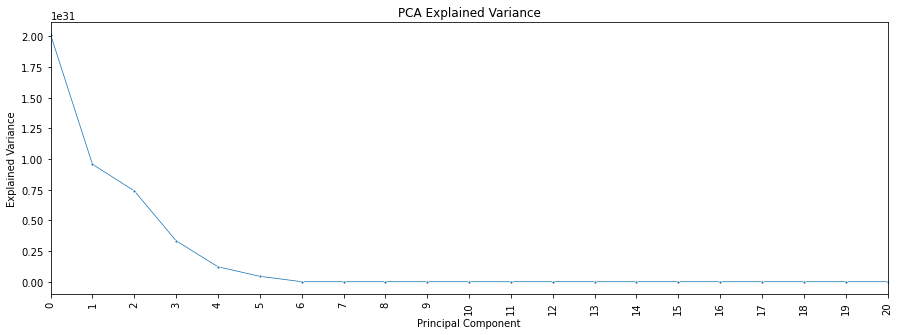

In [17]:
#Now that we have our scaled features, let's initialiez a PCA
#and see how our 159 features contribute to the variance.

pca = PCA()
pca.fit(X)

fig, ax = plt.subplots(figsize=(15,5))
y_pca = pca.explained_variance_
x_pca = np.arange(len(y_pca))
_=sns.lineplot(x_pca,y_pca, marker='.', size=20, legend=False)
_=plt.ylabel('Explained Variance')
_=plt.xlabel('Principal Component')
_=plt.title('PCA Explained Variance')
_=plt.xticks(np.arange(len(y_pca)), rotation=90)
_=plt.xlim([0, 20]) #truncate after 20, so we can more easily see the elbow point

#the elbow point (subjective) seems to occur around 4. 

In [23]:
np.arange(5)

array([0, 1, 2, 3, 4])

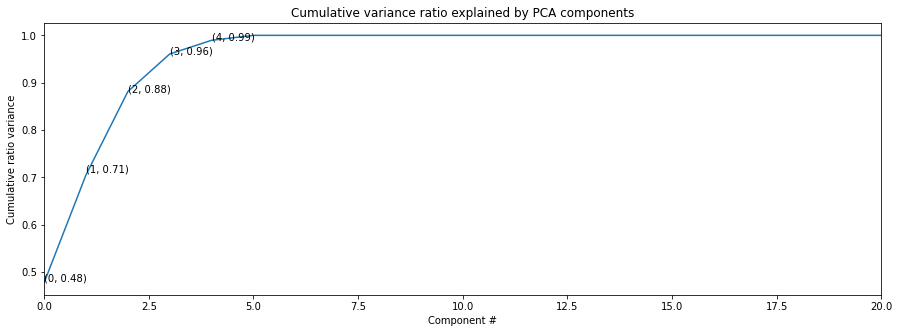

In [37]:
_=plt.subplots(figsize=(15, 5))
_=plt.plot(pca.explained_variance_ratio_.cumsum())
_=plt.xlabel('Component #')
_=plt.ylabel('Cumulative ratio variance')
_=plt.title('Cumulative variance ratio explained by PCA components')

# _=plt.axvline(1, linewidth=1, color='r', linestyle='--')
# _=plt.axvline(2, linewidth=1, color='r', linestyle='--')
# _=plt.axvline(3, linewidth=1, color='r', linestyle='--')
# _=plt.axvline(4, linewidth=1, color='r', linestyle='--')
# _=plt.axvline(5, linewidth=1, color='r', linestyle='--')


#Annotate the first few points
B = []
C = pca.explained_variance_ratio_.cumsum()[0:5]
for i in C:
    B.append(round(i,2))
A=np.arange(len(B))

for xy in zip(A, B):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    
    
_=plt.xlim([0, 20])
_=plt.show()

C:\Users\grace\anaconda3\envs\TestEnv7\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-38-a5300080e555>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_categorized.loc[(y_categorized.order_3 >= 0.08),:] = 1
<ipython-input-38-a5300080e555>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_categorized.loc[(y_categorized.order_3 < 0

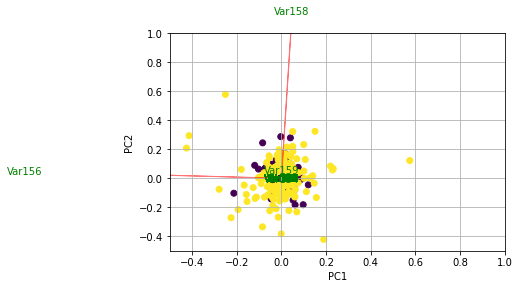

In [38]:
#Below is code to plot a PCA biplot, adapted from the author Serafeim Loukas of the following article:
# https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

pca = PCA()
x_new = pca.fit_transform(X)

#Color-code the points by categorizing one column in y as >= 8% TAC or <8%
y_categorized = y[['order_3']]
y_categorized.loc[(y_categorized.order_3 >= 0.08),:] = 1
y_categorized.loc[(y_categorized.order_3 < 0.08),:] = 0

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y_categorized.order_3)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-0.5,1)
plt.ylim(-0.5,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.

myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

From our PCA, we can see that the first 4 components already explain more than 95% of the variance of our dataset. If we look at the graph of explained variance, and use the "elbow method", we see the steepness of the curve decrease after component 4.

If we take a look at our first two components plotted as a biplot, due to the great overlap between the categories of >= 0.08 TAC and < 0.08 TAC, it's not clear whether there is a clear pattern between the components and whether someone is legally intoxicated or not. We can explore this further in our next notebook, when we do some feature engineering and find feature importance in some preliminary random forest models.

Below we look at the correlation heatmap of our dataframe.

In [50]:
#we'll only look at a subset of our columns. Use this section to select columns of interest.
print(df.columns[0:70])
print(df.columns[-20:])

Index(['x', 'y', 'z', 'order_3', 'order_5', 'order_7', 'order_9', 'x_jerk',
       'x_snap', 'x_mean', 'x_std', 'x_var', 'x_median', 'x_max_raw',
       'x_min_raw', 'x_max_abs', 'x_min_abs', 'x_skew', 'x_kurtosis', 'x_zcr',
       'x_gait_stretch', 'x_steps', 'x_step_time', 'x_rms', 'x_jerk_mean',
       'x_jerk_std', 'x_jerk_var', 'x_jerk_median', 'x_jerk_max_raw',
       'x_jerk_min_raw', 'x_jerk_max_abs', 'x_jerk_min_abs', 'x_jerk_skew',
       'x_jerk_kurtosis', 'x_jerk_zcr', 'x_jerk_gait_stretch', 'x_jerk_steps',
       'x_jerk_step_time', 'x_jerk_rms', 'x_snap_mean', 'x_snap_std',
       'x_snap_var', 'x_snap_median', 'x_snap_max_raw', 'x_snap_min_raw',
       'x_snap_max_abs', 'x_snap_min_abs', 'x_snap_skew', 'x_snap_kurtosis',
       'x_snap_zcr', 'x_snap_gait_stretch', 'x_snap_steps', 'x_snap_step_time',
       'x_snap_rms', 'y_jerk', 'y_snap', 'y_mean', 'y_std', 'y_var',
       'y_median', 'y_max_raw', 'y_min_raw', 'y_max_abs', 'y_min_abs',
       'y_skew', 'y_kurtosis', 'y_

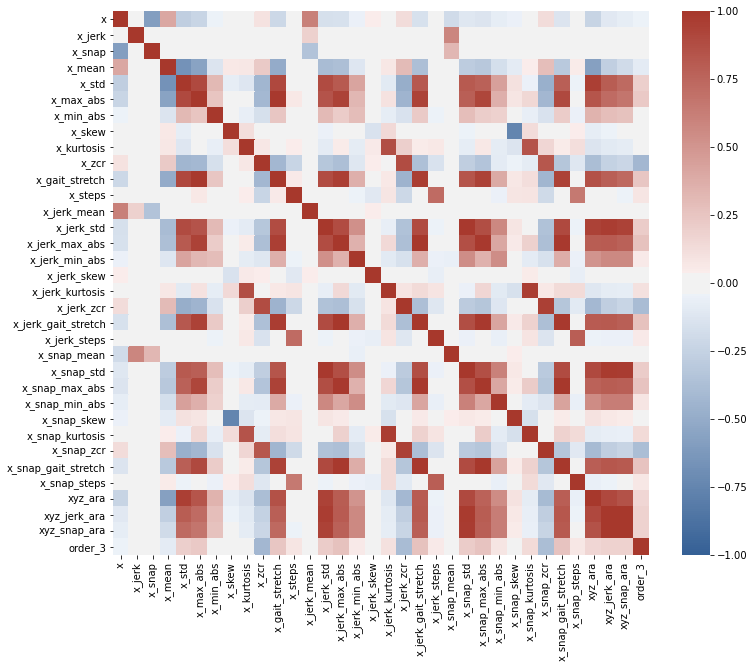

In [62]:
#Since it's a bit overwhelming and not visually useful to visualize 159 columns, we should narrow it down.
#Let's look only at a subset of the data.

col_list = ['x', 'x_jerk','x_snap', 
            'x_mean', 'x_std', 'x_max_abs', 'x_min_abs', 'x_skew', 'x_kurtosis', 'x_zcr', 'x_gait_stretch', 'x_steps',
            'x_jerk_mean', 'x_jerk_std', 'x_jerk_max_abs', 'x_jerk_min_abs',
            'x_jerk_skew', 'x_jerk_kurtosis', 'x_jerk_zcr', 'x_jerk_gait_stretch', 'x_jerk_steps',
            'x_snap_mean', 'x_snap_std', 'x_snap_max_abs', 'x_snap_min_abs', 
            'x_snap_skew', 'x_snap_kurtosis', 'x_snap_zcr', 'x_snap_gait_stretch', 'x_snap_steps',
            'xyz_ara', 'xyz_jerk_ara', 'xyz_snap_ara', 'order_3']
plt.subplots(figsize=(12,10))
cmap = sns.diverging_palette(250, 15, s=75, l=40, as_cmap=True)
sns.heatmap(df[col_list].corr(), vmin = -1, vmax = 1, cmap=cmap);

Looking at the heatmap, we want to see if the column labeled "order_3" (i.e. the Transdermal Alcohol Content, with missing data interpolated with a 3rd order polynomial), whether "order_3" is correlated with any of the other variables.

At a quick glance, we can see that "order_3" has a slight negative correlation with the zero crossing rates of x, x_jerk, and x_snap. This seems to imply that as the blood alcohol content (BAC) of the participant increases, there are fewer sign changes (i.e. directional changes) along the x-axis, perhaps indicating less movement. There seems to be some slight positive correlation with the gait stretch, standard deviation, and maxima of the absolute values of the accelerometer data. This implies possibly that as BAC increases, the individual takes larger stride sizes (gait stretch), has more variability in their movement (standard deviation) and more extreme/erratic movement (larger maxima).

Below we look at scatterplots of the scaled data. We can use the seaborn's pairplot to see how each feature varies with one another.

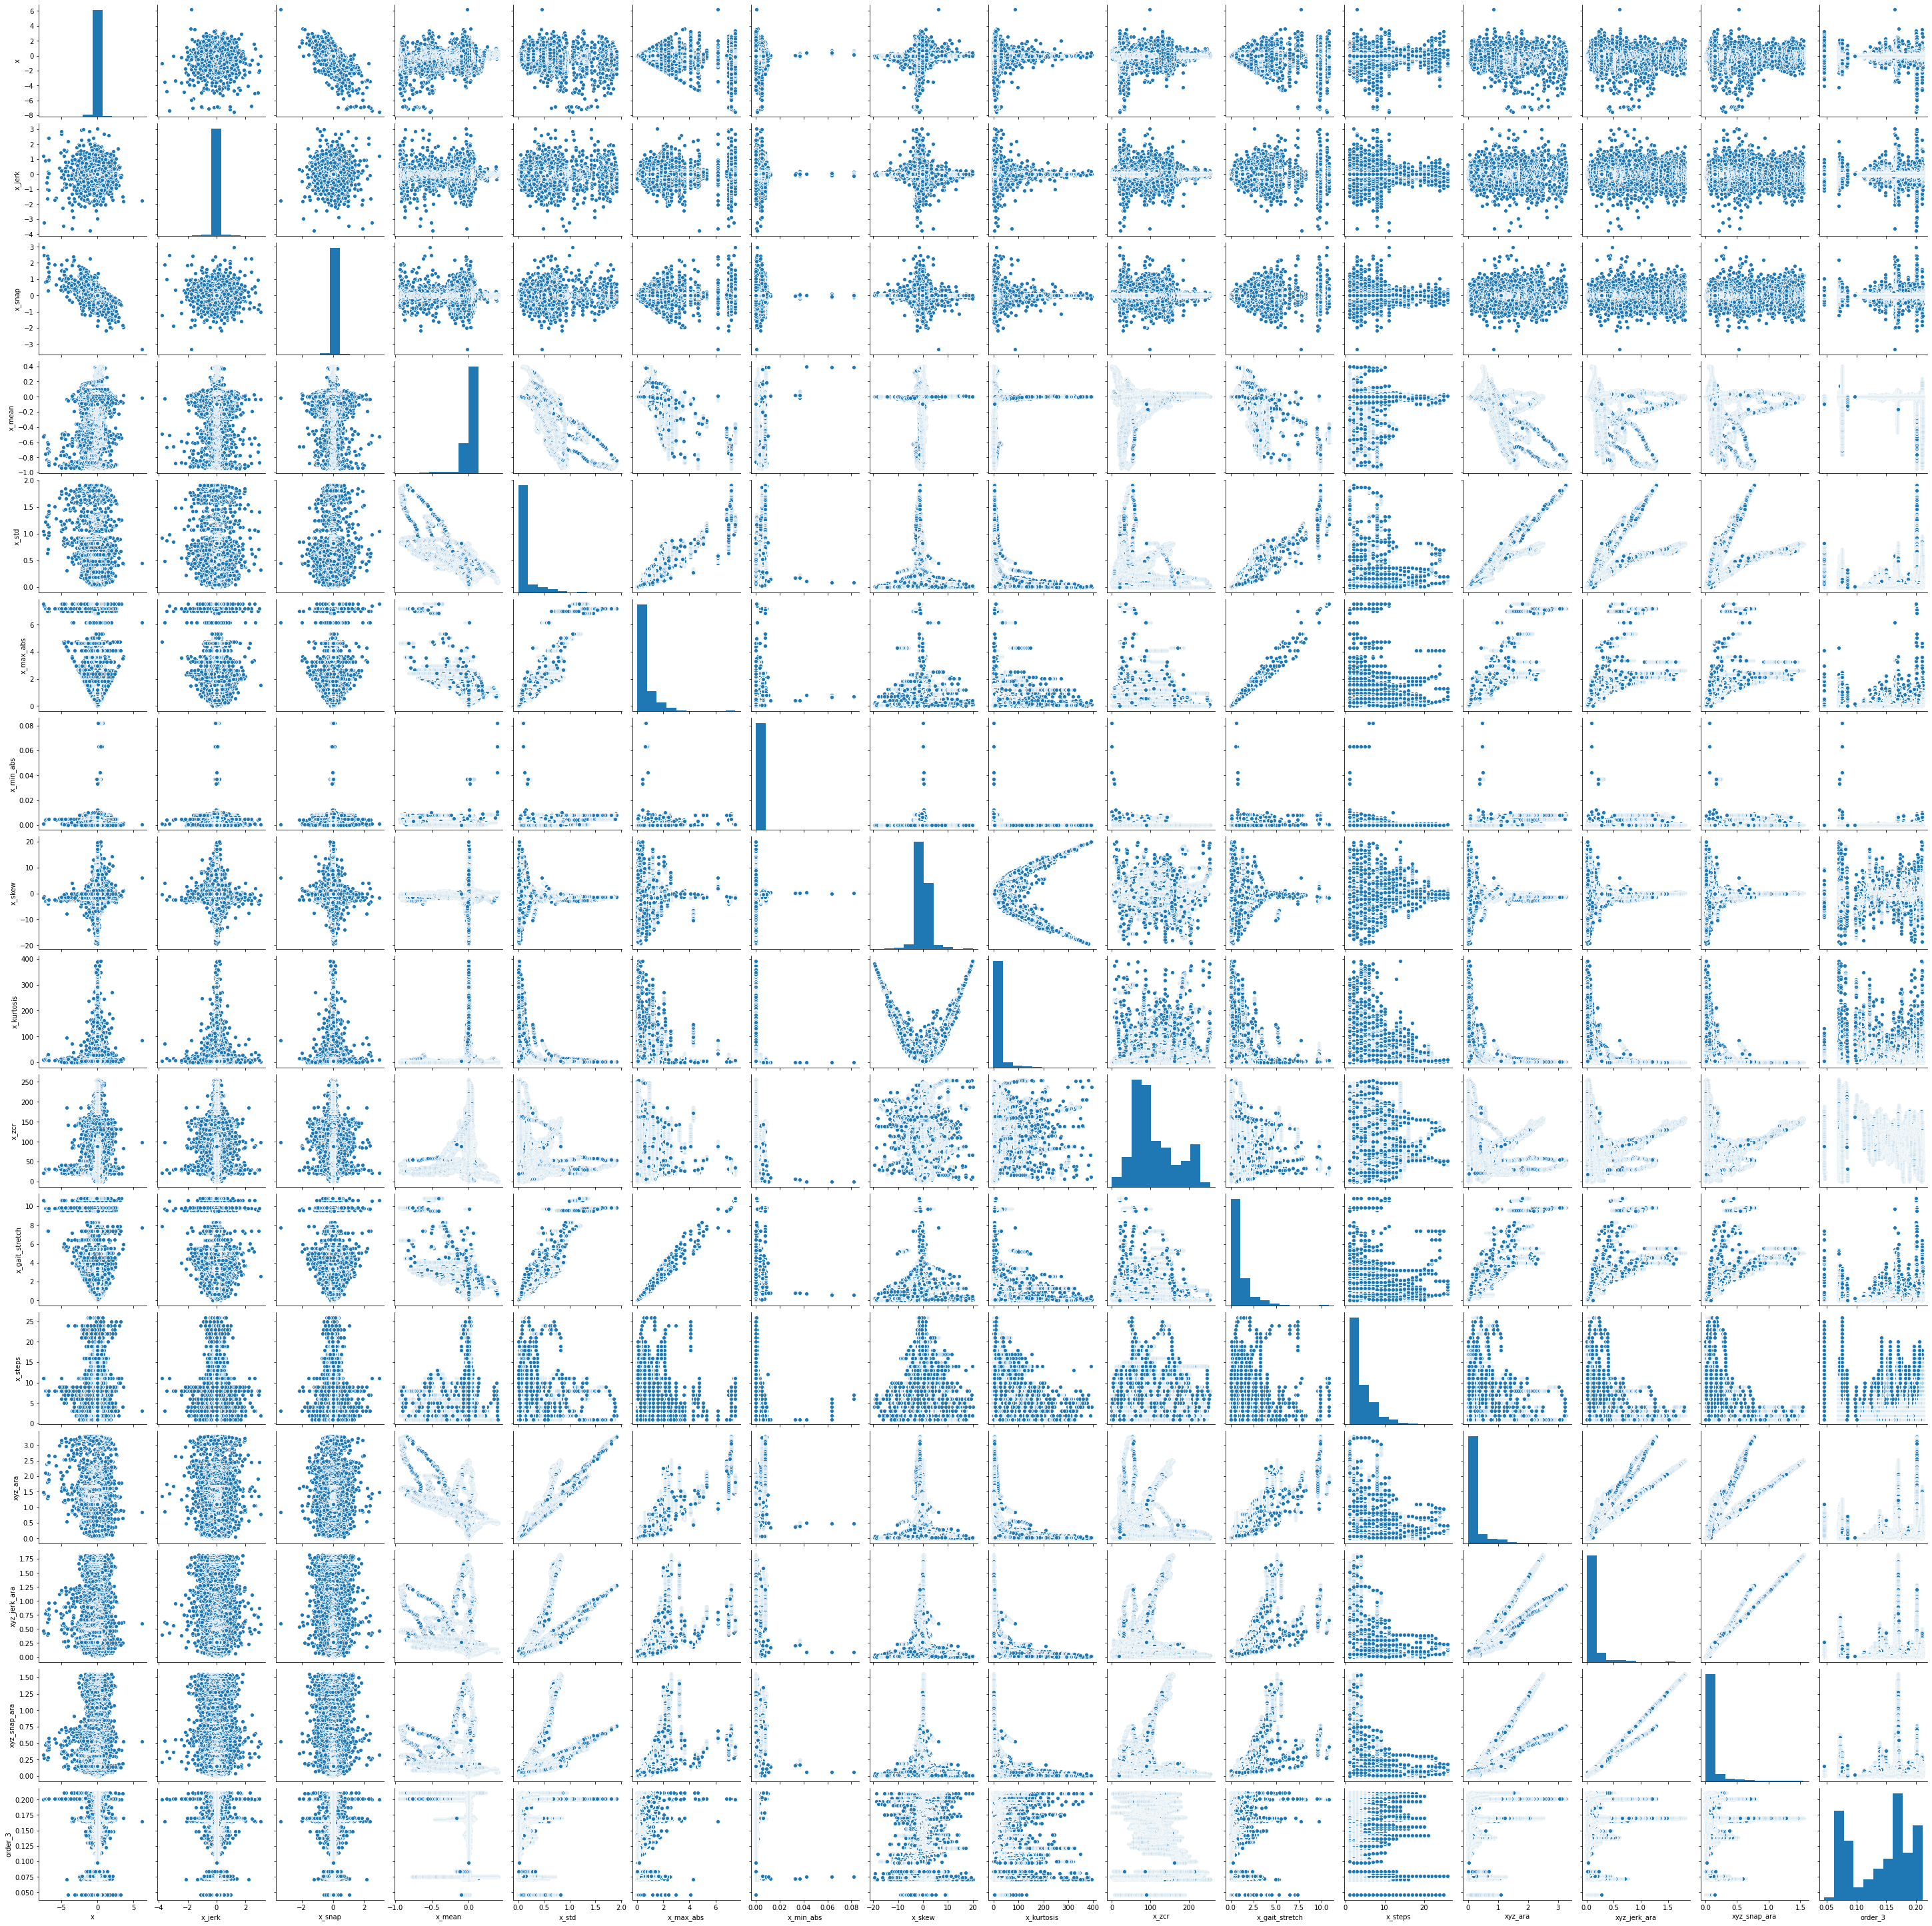

In [63]:
#Like before for the heatmap, let's look only at the tma data.
#Because we have 1.6 million rows from pid3, running pairplot can cause us to run out of memory.
#Instead, let's run a small subset, looking only at the x-axis features.

x_col_list = ['x', 'x_jerk','x_snap', 
            'x_mean', 'x_std', 'x_max_abs', 'x_min_abs', 'x_skew', 'x_kurtosis', 'x_zcr', 'x_gait_stretch', 'x_steps',
            'xyz_ara', 'xyz_jerk_ara', 'xyz_snap_ara', 'order_3']

sns.pairplot(df[x_col_list])

Looking at the seaborn pairplot, the series of plots we want to focus on are the ones relating to "order_3", i.e. the TAC data. Unfortunately, it does not appear to have a clear correlation with any of the features shown. Knowing this, we could see that methods like linear regression would not be suitable, and rather we would want to use somthing like a Random Forest model.

Finally, let's take a look at some boxplots to visualize the distribution of our data, grouped by the TAC data as a categorical variable (1 for BAC >= 8%, 0 for <8%).

In [67]:
#Similarly to before, let's look only at one of axes features.

#select just one of the dependent variables, and convert it into categorical.
df_boxplot = df[col_list]
df_boxplot_drunk = df_boxplot.loc[(df_boxplot.order_3 >= 0.08)]
df_boxplot_sober = df_boxplot.loc[(df_boxplot.order_3 < 0.08)]

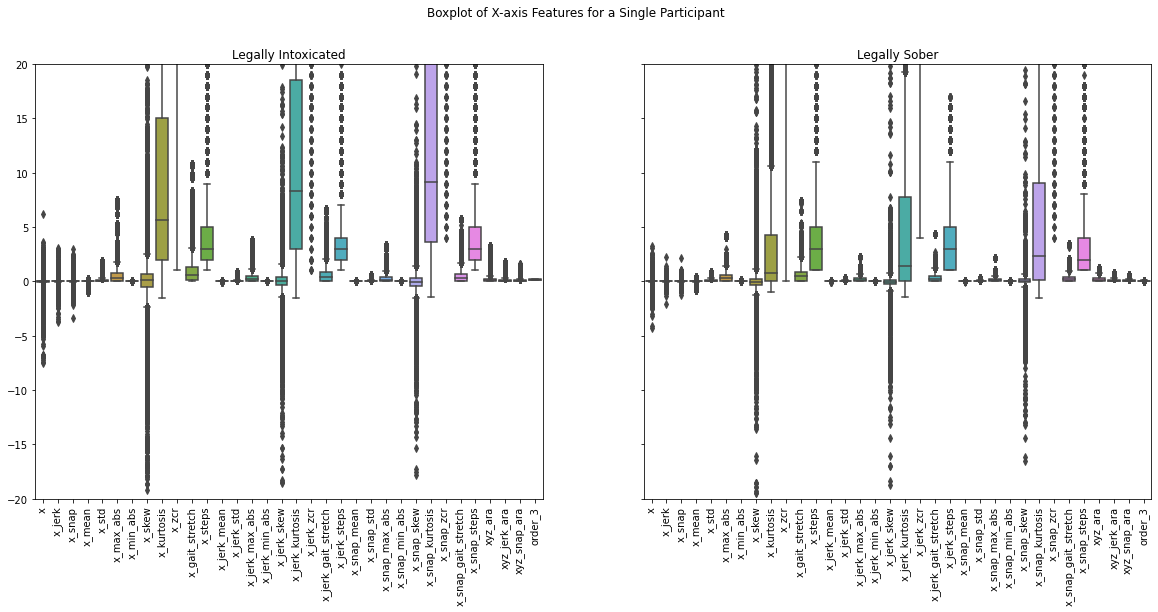

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Boxplot of X-axis Features for a Single Participant')

sns.boxplot(ax=axes[0], data = df_boxplot_drunk)
axes[0].set_title('Legally Intoxicated')
axes[0].set_xticklabels(df_boxplot_drunk.columns,rotation=90)

sns.boxplot(ax=axes[1], data = df_boxplot_sober)
axes[1].set_title('Legally Sober');
axes[1].set_xticklabels(df_boxplot_drunk.columns,rotation=90);

_=plt.ylim([-20, 20]) #truncate after 20, so we can more easily see the elbow point


Comparing the drunk and sober boxplots, we can see that in the sober data, the interquartile range for most features is smaller than that of the drunk features. This seems to imply that here is more variation in movement for the drunk individual.

### 3.5 Summary and Next Steps<a id='3.5_Summary_and_Next_Steps'></a>

__Summary of the Notebook:__

* We shifted the TAC data (subtracted the 45-minute lag between blood alcohol content and detection of transdermal alcohol content) in order to align the accelerometer data with the changes in the TAC.
* We imputed the missing TAC data in two ways, generating multiple sets of TAC data. 
 * In the first method, we interpolated with a polynomial fitting on the 3rd, 5th, 7th, and 9th orders. 
 * In the second method, we smoothed the TAC data first with a triangular moving average of window size 3 (1.5 hours, as each TAC datapoint is measured per 30 minutes), followed by interpolation with a 3rd order polynomial fitting. We also used a triangular moving average to make a smoothed set of the accelerometer data.
* We used the "multiprocessing" package to decrease our processing time to featurize and export each dataframe as a CSV file.
* We made the following features in 6-fold sets (x, y, and z axis, plus their smoothed counterparts x_tma, y_tma, and z_tma) using the pandas rolling() method over 10-second windows:
 * Mean
 * Standard Deviation
 * Variance
 * Median
 * Max (of raw and of absolute signal)
 * Min (of raw and of absolute signal)
 * Skew
 * Kurtosis
 * Zero Crossing Rate
 * Gait stretch
 * Number of steps
 * Step Time
 * RMS
 * Average Resultant Acceleration
 * Jerk (and the above features for Jerk).
 * Snap (and the above features for Snap). 
* We investigated relationships between features using PCA, correlation heatmaps, scatterplots, histograms, and boxplots.
 * From PCA, we learned that only the first 4 components from PCA contribute to more than 95% of the variance. But when we looked at the biplot of the first 2 components, there does not appear to have a clear visual distinction between the characteristics of the participant when they are legally drunk versus when they are legally sober.
 * From the correlation heatmaps, scatterplots, histograms, and boxplots, there does not appear to be an obvious relationship between any of the features and the participant's Transdermal Alcohol Content. However, there visually appears in the boxplots to be less variation in the features for the participant when they are sober compared to when they are intoxicated.
 * This investigation indicates we may want to generate more features (such as the standard deviation of our features, or changes of our features over time, etc.) that would help us to better predict whether someone would become intoxicated or not based on their phone accelerometer data.

__Next Steps:__

We saw from the seaborn pairplot that there was no feature with a clear correlation with alcohol level. Rather than trying a method like linear regression, we should start with Random Forest (in fact, we can use RF as a baseline, since this was found to be the best method by the authors of the paper), followed by XG Boost and possibly other models.